In [24]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import numpy as np
import time, re
import matplotlib.pyplot as plt
from IPython import display
import timeit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [25]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [26]:
use_kmers = True
N1 = 32
N2 = 8
lr = 0.05

In [27]:
fn_save_prefix = 'RegressData/Regress_Feb16_data_'
# save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu', 'genes']
save_vars = ['rnau','genes']
for var in save_vars:
    fn_save = fn_save_prefix+var+'.pkl'
    cmd = '%s=pd.read_pickle("%s")' % (var, fn_save)
    exec(cmd)
    print('Loaded %s' % fn_save)

if use_kmers:
    with np.load('RegressData/Regress_Feb16_data_kmer_countsu.npz', allow_pickle=True) as x:
        kmer_countsu=x['kmer_countsu']
    K=kmer_countsu.shape[1]
else:
    K=0
    
kmer_countsu.shape

Loaded RegressData/Regress_Feb16_data_rnau.pkl
Loaded RegressData/Regress_Feb16_data_genes.pkl


(62698, 2080)

In [28]:
with np.load('RegressData/Regress_Feb16_data_AllLookups.npz',allow_pickle=True) as data:
    ml_lookup=data['ml_lookup']
    atac_lookup=data['atac_lookup']
    rna_lookup=data['rna_lookup']
    kmeri_lookup=data['kmeri_lookup']

In [29]:
# def get_data(ensid):
#     # For a list of ensids, return the x and y features
#     x = []
#     for i,ens in enumerate(ensid):
#         curr_enh = genes2enhu.loc[ens,['enh_pos','enh_num']]
# #         curr_enh = curr_enh[:1]
# #         E = curr_enh.groupby('ensid').count().max(axis=0);
#         mlu = df_mlevelu.loc[curr_enh['enh_pos']]
#         atacu = df_atacu.loc[curr_enh['enh_pos']]
#         Ne,Nc = mlu.shape
#         if use_kmers:
#             kmeru = kmer_countsu[curr_enh['enh_num']]
#             Ne,Nk = kmeru.shape
#             kmeru = kmeru[:,np.newaxis,:]
#             kmeru = np.broadcast_to(kmeru,(Ne,Nc,Nk))
#             x1 = np.dstack((mlu,atacu,kmeru))
#         else:
#             x1 = np.dstack((mlu,atacu))
#         x1 = x1[np.newaxis,:,:,:]
#         x.append(x1)
    
#     # Pad the dimensions
#     max_nenh = np.max([xi.shape[1] for xi in x])
#     xpad = []
#     for xi in x:
#         xpad.append(np.pad(xi, ((0,0),(0,max_nenh-xi.shape[1]),(0,0),(0,0))))
#     x = np.concatenate(xpad, axis=0)

#     y = rnau.loc[ensid].to_numpy().reshape((-1,Nc))
    
#     # Testing:
#     for c in range(Nc):
#         y[:,c] = y[:,c]*0+c+0.123
    
#     x = torch.tensor(x, dtype=torch.float)
#     y = torch.tensor(y, dtype=torch.float)
    
#     return {'x': x, 'y': y}


Nkmers = kmer_countsu.shape[1]
Nc = ml_lookup.shape[2]
def get_data_index(ensid_index):
    # For a list of ensids, return the x and y features
    Ng = len(ensid_index)
    mlu = ml_lookup[ensid_index,:,:] # Ngenes x Ne x Nc
    atacu = atac_lookup[ensid_index,:,:]
    if use_kmers:
        nz = np.max([len(kmeri_lookup[x]) for x in ensid_index])
        kmeru = np.zeros((Ng,nz,1,Nkmers))
        for i,ens in enumerate(ensid_index):
            kmeru[i,:len(kmeri_lookup[ens]),0,:] = kmer_countsu[kmeri_lookup[ens],:]
    else:
        nz = (np.sum(atacu>0,axis=(0,2))+np.sum(mlu>0,axis=(0,2)))>0
        kmeru = []

    # Keep only the enhancers that have data
    mlu = mlu[:,:nz,:,np.newaxis]
    atacu = atacu[:,:nz,:,np.newaxis]

    kmeru = np.broadcast_to(kmeru, (Ng,nz,Nc,Nkmers))
    x = np.concatenate((mlu,atacu,kmeru),axis=3)
    y = rna_lookup[ensid_index,:]
    
#     # Testing:
#     for c in range(Nc):
#         y[:,c] = y[:,c]*0+c+0.123
    
    kmeru = torch.tensor(kmeru, dtype=torch.float)
    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    
    return {'x': x, 'kmeru': kmeru, 'y': y}

In [30]:
data=get_data_index([10])
data['x'].shape

torch.Size([1, 21, 28, 2082])

In [31]:
Nc = ml_lookup.shape[2]

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(2+K, N1);
        self.fc2 = nn.Linear(3*N1, N2);
        self.fc3 = nn.Linear(N2*Nc, Nc);
    def forward(self, x): 
        x = F.relu(self.fc1(x)) # In: N x Eg x C x (2+K), Out: N x Eg x C x N1
        
        # Collapse across enhancers in different ways
        xmax = torch.max(x, 1)[0]       # Out: N x C x N1
        xmean = torch.mean(x, 1)       # Out: N x C x N1
        xsum = torch.sum(x, 1)       # Out: N x C x N1
        
        x = torch.cat((xmax,xmean,xsum),2) # Out: N x C x 3*N1

        x = F.relu(self.fc2(x))       # Out: N x C x N2
        x = torch.reshape(x,(-1,N2*Nc)) # Out: N x C
        x = self.fc3(x)
        
        return x

In [32]:
net = Net()
if device is not "cpu":
    net.to(torch.device(device))
device

device(type='cuda', index=0)

In [33]:
ensids = rnau.index.values
net(get_data_index(np.arange(5))['x'].to(device)).shape
# get_data(ensids[:15])['x'].shape, get_data(ensids[:2])['y'].shape

torch.Size([5, 28])

In [34]:
mseloss=nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1)

running_time = 0
loss_vec = corr_vec = []
nepochs = 0

loss_test=np.array([])
loss_train = np.array([])
nparams = np.array([])
l1params = np.array([])

# Train/Test split
test = [c in ['chr10','chr12','chr14'] for c in rnau.join(genes)['chr']];
train = [not i for i in test]

test = np.random.permutation(np.nonzero(test)[0]).squeeze()
train = np.random.permutation(np.nonzero(train)[0]).squeeze()

ensids = rnau.index.values

In [35]:
import datetime
today=datetime.datetime.today().strftime('%d-%m-%Y')
fn_save = 'Regress_pytorch_N_%d_%d.%s.torch' % (N1,N2,today)
fn_save

'Regress_pytorch_N_32_8.20-02-2020.torch'

In [36]:
batch_size = 10
i = 10
def testfn():
    indices = train[i:i+batch_size]
    print(indices)

    # Input should be of size: (batch, channels, samples)
#     batch_data = get_data(ensids[indices])
    batch_data = get_data_index(indices)
    batch_X = batch_data['x']
    batch_y = batch_data['y']
#         print(batch_X.shape, batch_y.shape)

    # Send training data to CUDA
    if device is not "cpu":
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(batch_X)
    loss = criterion(outputs, batch_y)
    loss.backward()
    optimizer.step()

In [37]:
loss_train, loss_test = np.array([]), np.array([])

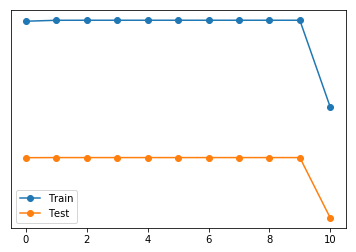

**** Epoch 13, LR=0.005, loss_train=0.23527392, loss_test=0.22294795, time = 1.57113 s/epoch
tensor([0.5784, 0.7040, 0.5780, 0.6657, 0.5604, 0.6436, 0.6663, 0.7529, 0.5129,
        0.4528, 0.5520, 0.7101, 0.6111, 0.5809, 0.6815, 0.6254, 0.7084, 0.6545,
        0.6379, 0.8029, 0.7519, 0.5434, 0.4388, 0.7367, 0.7813, 0.7099, 0.4996,
        0.5874], device='cuda:0', grad_fn=<SliceBackward>)
Saved data: Regress_pytorch_N_32_8.20-02-2020.torch
Epoch 14, i=913/3491, loss=0.23344054, t=5.005, 0.00548 s/sample
tensor([0.6575, 0.7864, 0.6676, 0.7439, 0.6546, 0.7356, 0.7454, 0.8472, 0.6151,
        0.5527, 0.6433, 0.8142, 0.7199, 0.6658, 0.7728, 0.6937, 0.8057, 0.7339,
        0.7332, 0.8747, 0.8360, 0.6604, 0.5561, 0.8125, 0.8485, 0.8074, 0.6058,
        0.7036], device='cuda:0', grad_fn=<SliceBackward>)


In [ ]:
criterion = nn.MSELoss()
num_epochs = 1000;
batch_size = 1;

t0 = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    nsamp = 0
    running_loss = 0.0
    running_time = 0.0
    net.train()
    t0train = time.time()
    for i in range(0, len(train), batch_size):
        tstart = time.time()
        indices = train[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(indices)
        batch_X = batch_data['x']
        batch_y = batch_data['y']
#         print(batch_X.shape, batch_y.shape)

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if np.isnan(running_loss):
            break
        running_time += time.time()-tstart
        nsamp += len(indices)
        if (time.time()-t0train)>5:
            print('Epoch %d, i=%d/%d, loss=%3.8f, t=%3.3f, %3.5f s/sample' % (epoch, i, len(train), 
                                                                              running_loss/nsamp, running_time, running_time/nsamp))
            t0train=time.time()
            print(outputs[0,:])

    loss_train = np.append(loss_train,running_loss/nsamp)
    scheduler.step(running_loss/nsamp)

    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    for i in range(0, len(test), batch_size):
        indices = test[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(indices)
        batch_X = batch_data['x']
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

        outputs = net(batch_X)
        loss = criterion(outputs, batch_y)
        running_loss_test += loss.item()
        nsamp += len(indices)
    loss_test = np.append(loss_test,running_loss_test/nsamp)

    if (time.time()-t0)>5 and epoch>3:
plt.clf()
plt.plot(loss_train[2:],'o-',label='Train')
plt.plot(loss_test[2:],'o-',label='Test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(fn_save)
plt.savefig('Plots/'+fn_save.replace('.torch','')+'_loss.png')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        print('**** Epoch %d, LR=%3.3f, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (epoch, 
                                                                                                    optimizer.state_dict()['param_groups'][0]['lr'], 
                                                                                                    loss_train[-1], 
                                                                                                    loss_test[-1], 
                                                                                                    (time.time()-t0)/epoch))
        print(outputs[0,:])
        t0=time.time()

    torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_train': loss_train,
            'loss_test': loss_test,
            }, fn_save)
    print('Saved data: %s' % fn_save)

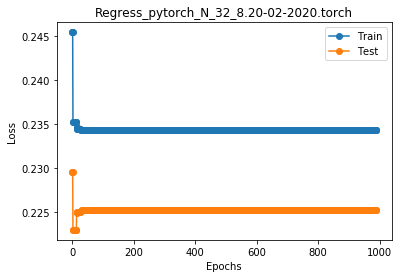

In [49]:
net.eval()
indices = test

yyhat = {'y':[], 'yhat':[]}
for i in range(0, len(test), batch_size):
    indices = test[i:i+batch_size]
    # Input should be of size: (batch, channels, samples)
    batch_data = get_data_index(indices)
    batch_X = batch_data['x']
    batch_y = batch_data['y']

    # Send training data to CUDA
    if device is not "cpu":
        batch_X = batch_X.to(device)

    outputs = net(batch_X)
    yyhat['yhat'].append(outputs.detach().cpu().numpy())
    yyhat['y'].append(batch_y.numpy())
yyhat['yhat'] = np.concatenate(yyhat['yhat'],axis=0)
yyhat['y'] = np.concatenate(yyhat['y'],axis=0)

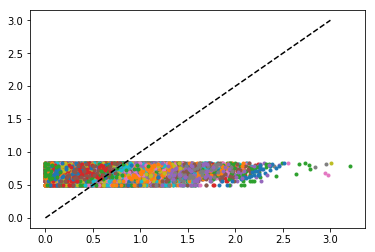

In [52]:
plt.plot(yyhat['y'].T, yyhat['yhat'].T,'.');
plt.plot([0,3],[0,3],'k--')

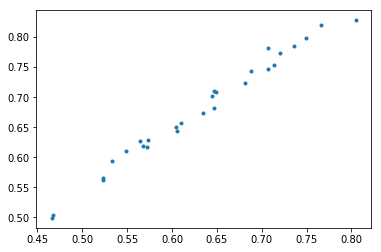

In [51]:
plt.plot(yyhat['y'].mean(axis=0), yyhat['yhat'].mean(axis=0),'.')